In [1]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 6.6 MB/s eta 0:00:00


In [2]:
#szokaásos könyvtárak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#black-litterman-hoz tartozó
from pypfopt import black_litterman
from pypfopt import risk_models, expected_returns
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

# optimalizalas
from scipy.optimize import minimize

# Kiszámoljuk a hozamokat a CAPM-mel

In [3]:
data = pd.read_excel('/content/data.xlsx',sheet_name='Havi',skiprows=1)
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index)
data.sort_index(ascending=False, inplace=True)
num_assets = len(data.columns)
colors = sns.color_palette("tab20", num_assets)

colors = sns.color_palette("tab20", num_assets)

# ez lehet más de igazából ez egy elég jó kiindulópont
data = data['2009-01-30':]

# 60:40 market portfólió
data['market'] = data['SP500']*0.3+data['MSCI World']*0.3+data['Global agg bond']*0.4

# benne van a fileban, most csak kivettem a jelenlegi értékét
rf = 0.042045566

# havi log hozamok
monthly_returns = np.log(data / data.shift(-1))

#béták
betas = monthly_returns.cov().loc[:, 'market'] / monthly_returns['market'].var()

market_return = monthly_returns['market'].mean()*12

# CAPM formula
market_views = rf + betas * (market_return - rf)

In [4]:
print(f'A piac hozama: {market_return}')

A piac hozama: 0.09801214096955443


## A picai hozamok

In [5]:
pd.options.display.float_format = '{:.2f}%'.format

market_views = market_views[[x for x in market_views.index if x != 'market']]
market_views*100

,market
SP500,10.42%
MSCI World,10.57%
MSCI MXEA,10.47%
MSCI EM,10.17%
Global agg bond,5.54%
US agg bond,4.79%
US corp HY,6.89%
Gold,5.20%
DAX,11.95%
MSFT,10.08%


# Hozamszámítás historikus átlaggal

- Valójában nekem az a fealadatom, hogy magát a módszert bemutassam, nem pedig az, hogy szakértői véleményem legyen a hozamokról, így a nézeteknek a hozamok átlagát fogom használni.

In [6]:
data = pd.read_excel('data.xlsx', sheet_name='Napi',skiprows=1)
data.set_index('Date', inplace=True)

data.index = pd.to_datetime(data.index)
data.sort_index(ascending=False, inplace=True)

#benne van a fileban, most csak kivettem a jelenlegi értékét
rf = 0.042045566
#itt ezzel lehet kiserletezni 22 elejetol 25 feb vegeig van adat
data = data.loc['2023-01-03':]

# napi log hozamok
daily_returns = np.log(data / data.shift(-1))
# évesített várható hozam
mean_returns = daily_returns.mean() * 250
mean_returns.rename('Return', inplace=True)
#piaci portfólió
market_ret = mean_returns['SP500']*0.3+mean_returns['MSCI World']*0.3+mean_returns['Global agg bond']*0.4
# levonjuk a risk free ratet
mean_returns = mean_returns - rf
# évesített kovariancia mátrix
cov_matrix = daily_returns.cov() * 250
corr_matrix = daily_returns.corr()
std = np.sqrt(np.diag(np.array(cov_matrix)))
std = pd.Series(index=mean_returns.index, data=std)


## Az én view-im

In [7]:
pd.options.display.float_format = '{:.2f}%'.format

mean_returns = mean_returns[[x for x in mean_returns.index if x != 'market']]
mean_returns*100


,Return
SP500,16.30%
MSCI World,13.41%
MSCI MXEA,5.60%
MSCI EM,1.86%
Global agg bond,-1.64%
US agg bond,-0.05%
US corp HY,5.98%
Gold,16.19%
DAX,16.61%
MSFT,19.18%


In [8]:
pd.options.display.float_format = '{:.2f}%'.format

std = std[[x for x in std.index if x != 'market']]
std.rename('Std', inplace = True)*100

,Std
SP500,12.86%
MSCI World,11.26%
MSCI MXEA,12.38%
MSCI EM,13.30%
Global agg bond,6.09%
US agg bond,6.29%
US corp HY,3.92%
Gold,14.20%
DAX,16.16%
MSFT,22.84%


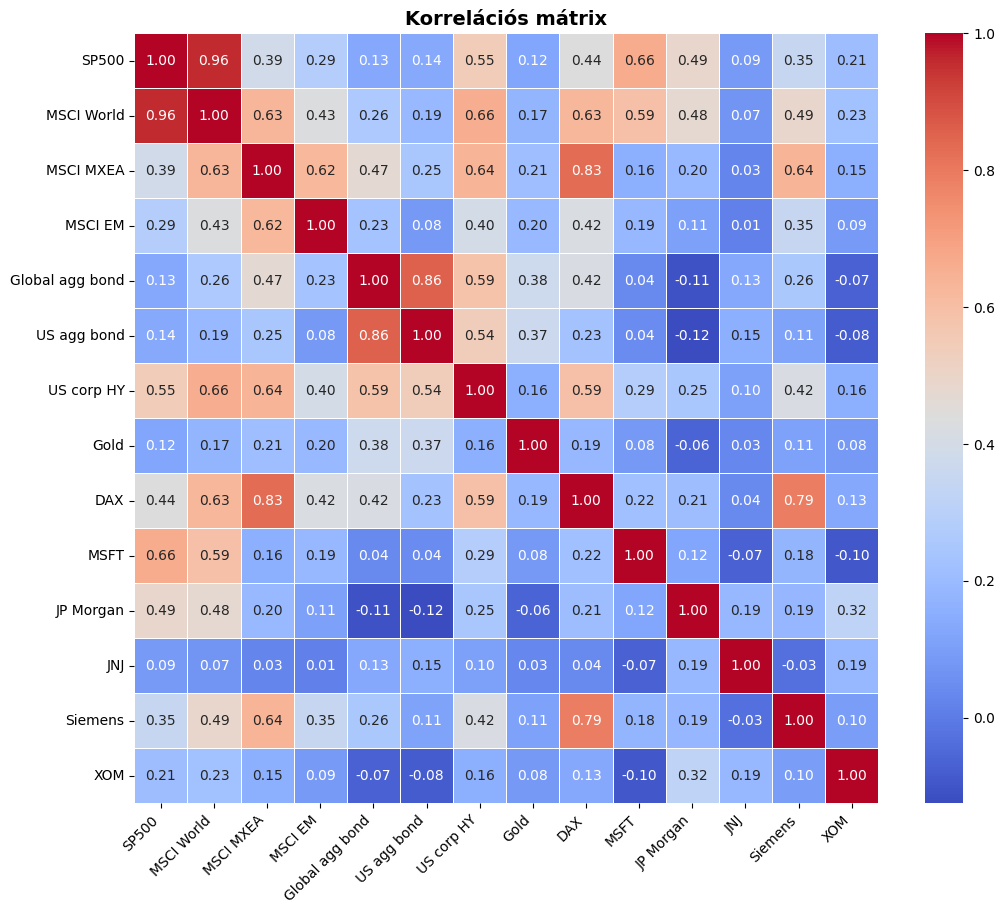

In [9]:

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelációs mátrix', fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


In [10]:
pd.options.display.float_format = '{:.2f}'.format
corr_matrix

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM
SP500,1.00,0.96,0.39,0.29,0.13,0.14,0.55,0.12,0.44,0.66,0.49,0.09,0.35,0.21
MSCI World,0.96,1.00,0.63,0.43,0.26,0.19,0.66,0.17,0.63,0.59,0.48,0.07,0.49,0.23
MSCI MXEA,0.39,0.63,1.00,0.62,0.47,0.25,0.64,0.21,0.83,0.16,0.20,0.03,0.64,0.15
MSCI EM,0.29,0.43,0.62,1.00,0.23,0.08,0.40,0.20,0.42,0.19,0.11,0.01,0.35,0.09
Global agg bond,0.13,0.26,0.47,0.23,1.00,0.86,0.59,0.38,0.42,0.04,-0.11,0.13,0.26,-0.07
US agg bond,0.14,0.19,0.25,0.08,0.86,1.00,0.54,0.37,0.23,0.04,-0.12,0.15,0.11,-0.08
US corp HY,0.55,0.66,0.64,0.40,0.59,0.54,1.00,0.16,0.59,0.29,0.25,0.10,0.42,0.16
Gold,0.12,0.17,0.21,0.20,0.38,0.37,0.16,1.00,0.19,0.08,-0.06,0.03,0.11,0.08
DAX,0.44,0.63,0.83,0.42,0.42,0.23,0.59,0.19,1.00,0.22,0.21,0.04,0.79,0.13
MSFT,0.66,0.59,0.16,0.19,0.04,0.04,0.29,0.08,0.22,1.00,0.12,-0.07,0.18,-0.10


In [11]:
views = mean_returns
views*100

,Return
SP500,16.30
MSCI World,13.41
MSCI MXEA,5.60
MSCI EM,1.86
Global agg bond,-1.64
US agg bond,-0.05
US corp HY,5.98
Gold,16.19
DAX,16.61
MSFT,19.18


In [12]:
pd.options.display.float_format = '{:.4f}'.format
cov_matrix

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM
SP500,0.0165,0.0139,0.0062,0.0049,0.0010,0.0011,0.0027,0.0022,0.0091,0.0194,0.0138,0.0018,0.0123,0.0059
MSCI World,0.0139,0.0127,0.0088,0.0064,0.0018,0.0014,0.0029,0.0028,0.0114,0.0153,0.0117,0.0013,0.0151,0.0056
MSCI MXEA,0.0062,0.0088,0.0153,0.0103,0.0036,0.0019,0.0031,0.0037,0.0166,0.0045,0.0053,0.0005,0.0217,0.0043
MSCI EM,0.0049,0.0064,0.0103,0.0177,0.0019,0.0007,0.0021,0.0037,0.0091,0.0058,0.0031,0.0002,0.0127,0.0026
Global agg bond,0.0010,0.0018,0.0036,0.0019,0.0037,0.0033,0.0014,0.0032,0.0041,0.0006,-0.0015,0.0013,0.0043,-0.0010
US agg bond,0.0011,0.0014,0.0019,0.0007,0.0033,0.0040,0.0013,0.0033,0.0023,0.0006,-0.0017,0.0016,0.0019,-0.0012
US corp HY,0.0027,0.0029,0.0031,0.0021,0.0014,0.0013,0.0015,0.0009,0.0037,0.0026,0.0021,0.0007,0.0045,0.0014
Gold,0.0022,0.0028,0.0037,0.0037,0.0032,0.0033,0.0009,0.0202,0.0043,0.0027,-0.0019,0.0007,0.0043,0.0026
DAX,0.0091,0.0114,0.0166,0.0091,0.0041,0.0023,0.0037,0.0043,0.0261,0.0081,0.0074,0.0011,0.0352,0.0047
MSFT,0.0194,0.0153,0.0045,0.0058,0.0006,0.0006,0.0026,0.0027,0.0081,0.0522,0.0061,-0.0025,0.0111,-0.0050


In [13]:
covv = risk_models.sample_cov(data.dropna() )
covv
#maradok az elsonel de azert meno hogy ilyen is van

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM
SP500,0.0167,0.0140,0.0063,0.0050,0.0010,0.0011,0.0028,0.0023,0.0092,0.0196,0.0139,0.0019,0.0124,0.0059
MSCI World,0.0140,0.0128,0.0089,0.0065,0.0018,0.0014,0.0029,0.0028,0.0115,0.0154,0.0118,0.0013,0.0153,0.0057
MSCI MXEA,0.0063,0.0089,0.0155,0.0104,0.0036,0.0019,0.0031,0.0037,0.0168,0.0046,0.0054,0.0006,0.0219,0.0043
MSCI EM,0.0050,0.0065,0.0104,0.0179,0.0019,0.0007,0.0021,0.0037,0.0092,0.0059,0.0032,0.0003,0.0128,0.0026
Global agg bond,0.0010,0.0018,0.0036,0.0019,0.0037,0.0033,0.0014,0.0033,0.0041,0.0006,-0.0014,0.0013,0.0043,-0.0010
US agg bond,0.0011,0.0014,0.0019,0.0007,0.0033,0.0040,0.0013,0.0033,0.0023,0.0006,-0.0017,0.0016,0.0019,-0.0012
US corp HY,0.0028,0.0029,0.0031,0.0021,0.0014,0.0013,0.0015,0.0009,0.0038,0.0026,0.0021,0.0007,0.0045,0.0014
Gold,0.0023,0.0028,0.0037,0.0037,0.0033,0.0033,0.0009,0.0203,0.0044,0.0028,-0.0018,0.0007,0.0043,0.0026
DAX,0.0092,0.0115,0.0168,0.0092,0.0041,0.0023,0.0038,0.0044,0.0264,0.0082,0.0075,0.0011,0.0356,0.0048
MSFT,0.0196,0.0154,0.0046,0.0059,0.0006,0.0006,0.0026,0.0028,0.0082,0.0527,0.0061,-0.0025,0.0112,-0.0050


# Black-Littermann modell


In [14]:
# Mapping, ez mondja meg melyik view hova megy, lehet abszolút meg relatív view-t is megadni
P = np.eye(num_assets)

# Itt rakjuk bele a viewkat
Q = (views.values).reshape(-1,1)

# Bizonytalanság
# 0 amikor teljesen biztos vagy a view-dban
# 1 amikor teljesen bizonytalan vagy a view-dban

uncertainty_list = [0, 0.001, 0.005, 0.01, 0.05] + [x*0.1 for x in range(1,11)] + [3]
posterior_returns_dict = {}
posterior_cov_dict = {}
for i in uncertainty_list:
  omega = np.diag([i]*num_assets)

  # Modell inicializalas
  bl = BlackLittermanModel(cov_matrix, pi=market_views, P=P, Q=Q, omega=omega)

  # Frissített várható hozamok és kovariancia
  posterior_returns = bl.bl_returns()
  posterior_returns_dict[i] = posterior_returns
  posterior_cov = bl.bl_cov()
  posterior_cov_dict[i] = posterior_cov



In [15]:
pd.options.display.float_format = '{:.2f}%'.format

posterior_returns = pd.DataFrame(posterior_returns_dict)
posterior_returns.columns = ['Views'] + [str(np.round(x,3)) for x in uncertainty_list[1:-1]] + ['Market']
posterior_returns.drop(columns=['1.0'], inplace=True)
posterior_returns * 100

,Views,0.001,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Market
SP500,16.30%,14.57%,12.81%,12.00%,10.85%,10.65%,10.54%,10.50%,10.48%,10.47%,10.46%,10.45%,10.45%,10.45%,10.43%
MSCI World,13.41%,13.41%,12.42%,11.84%,10.93%,10.76%,10.66%,10.63%,10.62%,10.61%,10.60%,10.59%,10.59%,10.59%,10.57%
MSCI MXEA,5.60%,9.42%,10.75%,10.83%,10.62%,10.56%,10.52%,10.50%,10.50%,10.49%,10.49%,10.49%,10.48%,10.48%,10.48%
MSCI EM,1.86%,7.10%,9.71%,10.08%,10.21%,10.20%,10.19%,10.18%,10.18%,10.18%,10.18%,10.18%,10.18%,10.18%,10.18%
Global agg bond,-1.64%,4.13%,5.23%,5.41%,5.53%,5.53%,5.54%,5.54%,5.54%,5.54%,5.54%,5.54%,5.54%,5.54%,5.54%
US agg bond,-0.05%,3.52%,4.48%,4.64%,4.77%,4.78%,4.78%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%
US corp HY,5.98%,6.60%,7.01%,7.01%,6.93%,6.91%,6.90%,6.89%,6.89%,6.89%,6.89%,6.89%,6.89%,6.89%,6.89%
Gold,16.19%,9.05%,6.32%,5.83%,5.35%,5.27%,5.24%,5.22%,5.22%,5.21%,5.21%,5.21%,5.21%,5.21%,5.20%
DAX,16.61%,13.79%,13.41%,13.05%,12.30%,12.14%,12.05%,12.02%,12.00%,11.99%,11.99%,11.98%,11.98%,11.98%,11.96%
MSFT,19.18%,18.13%,14.73%,13.11%,10.88%,10.50%,10.29%,10.22%,10.19%,10.16%,10.15%,10.14%,10.13%,10.13%,10.09%


# Határportfólió görbék

Most nézzük, meg hogy változik meg maga a határportfólió görbe az új eredményekkel

In [16]:
pd.options.display.float_format = '{:.3f}'.format
# portfólió varinciája
def portfolio_variance(weights):
    return weights.T @ cov_matrix @ weights

# portfólió varianciája bl
def portfolio_variance_bl(weights, uncertainty):
    return weights.T @ posterior_cov_dict[uncertainty] @ weights

# portfólió hozama
def portfolio_return(weights):
    return np.dot(weights, mean_returns)

# portfólió hozama bl
def portfolio_return_bl(weights, uncertainty):
    return np.dot(weights, posterior_returns_dict[uncertainty])

# max portfoliohoz
def portfolio_return_neg(weights):
    return -np.dot(weights, mean_returns)

# max portfoliohoz
def portfolio_return_neg_bl(weights, uncertainty):
    return -np.dot(weights, posterior_returns_dict[uncertainty])

# hasznossági függvény negativan adom meg hogy minimalizalni kelljen
def utility_function(weights, gamma):
    return -portfolio_return(weights) + gamma/2 *portfolio_variance(weights)

def utility_function_bl(weights, gamma, uncertainty):
    return -portfolio_return_bl(weights, uncertainty) + gamma/2 *portfolio_variance_bl(weights, uncertainty)


#1 re összegződjenek a súlyok
def constraints_weight():
    return [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    ]

#Határportfólió görbe számolásához
def constraints(target_return):
    return [
        {'type': 'eq', 'fun': lambda weights: portfolio_return(weights) - target_return},
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    ]

def constraints_bl(target_return,uncertainty):
    return [
        {'type': 'eq', 'fun': lambda weights: portfolio_return_bl(weights, uncertainty) - target_return},
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    ]

# korlátok
bounds_short_allowed = tuple((-1, 1) for _ in range(num_assets))
bounds_without_shortselling = tuple((0, 1) for _ in range(num_assets))

# kezdőpont
initial_guess = np.array([1/num_assets]*num_assets)

## Shortselling engedélyezett

Különböző view-b vetett bizalomi szint mellett kirajzoljuk a görbéket

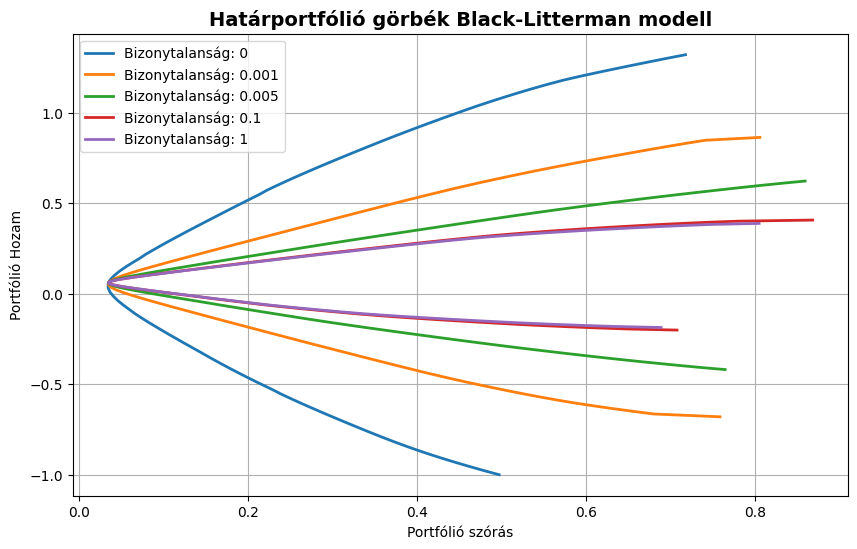

In [17]:
unc_list = [0, 0.001, 0.005, 0.1, 1]
plt.figure(figsize=(10, 6))

for unc in unc_list:
  result = minimize(lambda w : portfolio_return_neg_bl(weights=w,uncertainty=unc), initial_guess,  method='SLSQP', bounds=bounds_short_allowed, constraints=constraints_weight())
  max_return_port = result.x
  result = minimize(lambda w : portfolio_return_bl(weights=w,uncertainty=unc), initial_guess,  method='SLSQP', bounds=bounds_short_allowed, constraints=constraints_weight())
  min_return_port = result.x

  target_returns = np.linspace(max(-1,portfolio_return_bl(min_return_port, unc)),portfolio_return_bl(max_return_port, unc), 100)
  frontier_risks = []

  for target_return in target_returns:
    initial_guess = np.array([1 / num_assets] * num_assets)
    result = minimize(lambda w: portfolio_variance_bl(weights=w, uncertainty=unc), initial_guess, method='SLSQP', bounds=bounds_short_allowed, constraints=constraints_bl(target_return, unc))
    frontier_risks.append(np.sqrt(portfolio_variance_bl(result.x, unc)))


  plt.plot(frontier_risks, target_returns,label=f'Bizonytalanság: {unc}', linewidth = 2)

plt.xlabel('Portfólió szórás', fontsize=10)
plt.ylabel('Portfólió Hozam', fontsize =10)
plt.title('Határportfólió görbék Black-Litterman modell', fontsize = 14, fontweight="bold")
plt.grid(True)
plt.legend()
plt.show()

## Shortselling nem engedélyezett

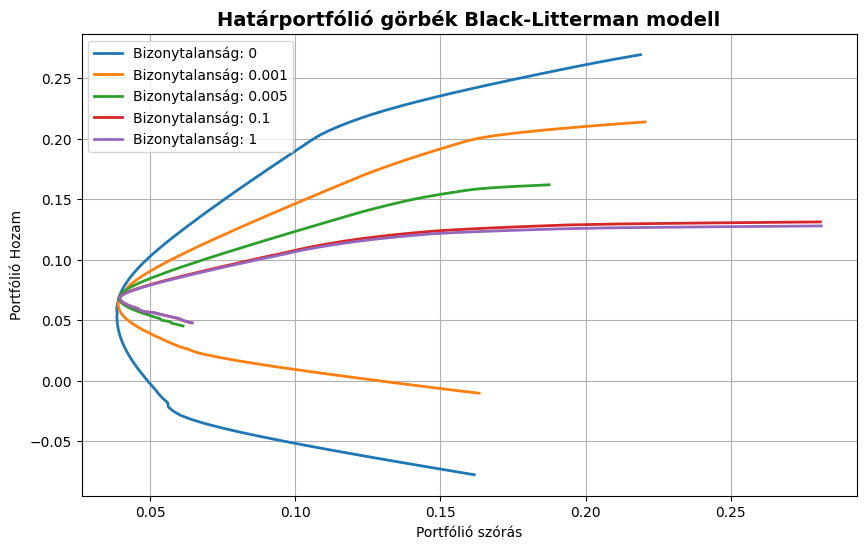

In [18]:
unc_list = [0, 0.001, 0.005, 0.1, 1]
plt.figure(figsize=(10, 6))

for unc in unc_list:
  result = minimize(lambda w : portfolio_return_neg_bl(weights=w,uncertainty=unc), initial_guess,  method='SLSQP', bounds=bounds_without_shortselling, constraints=constraints_weight())
  max_return_port = result.x
  result = minimize(lambda w : portfolio_return_bl(weights=w,uncertainty=unc), initial_guess,  method='SLSQP', bounds=bounds_without_shortselling, constraints=constraints_weight())
  min_return_port = result.x

  target_returns = np.linspace(max(-1,portfolio_return_bl(min_return_port, unc)),portfolio_return_bl(max_return_port, unc), 100)
  frontier_risks = []

  for target_return in target_returns:
    initial_guess = np.array([1 / num_assets] * num_assets)
    result = minimize(lambda w: portfolio_variance_bl(weights=w, uncertainty=unc), initial_guess, method='SLSQP', bounds=bounds_without_shortselling, constraints=constraints_bl(target_return, unc))
    frontier_risks.append(np.sqrt(portfolio_variance_bl(result.x, unc)))


  plt.plot(frontier_risks, target_returns,label=f'Bizonytalanság: {unc}', linewidth = 2)

plt.xlabel('Portfólió szórás', fontsize=10)
plt.ylabel('Portfólió Hozam', fontsize =10)
plt.title('Határportfólió görbék Black-Litterman modell', fontsize = 14, fontweight="bold")
plt.grid(True)
plt.legend()
plt.show()

# Optimális portfólió meghatározása

1. Elsőként a kockázatkerülét változtatjuk
2. Megnézzük, hogy különböző view-khoz tartozó konfidencia intervallumok milyen portfóliókat eredményeznek  
3. Megpróbálunk egy szereplő asset-hez negativ viewt megadni hogy kitúrjuk a portfóliónkból


## A kockázatéhségen iterálunk

### Shortselling **engedélyezett**

In [19]:
gamma = [0,2,4,6,8] + [10*x for x in range(1,11)]
uncer = 0.001   #ezen az erteken lehet valtoztatni

optimal_portfolios = pd.DataFrame(index=gamma, columns = list(mean_returns.index) + ['return', 'std'])

for g in gamma:
    initial_guess = np.array([1 / num_assets] * num_assets)
    result = minimize(lambda w: utility_function_bl(w, g, uncer), initial_guess,
                      method='SLSQP', bounds=bounds_short_allowed,
                      constraints=constraints_weight())
    optimal_portfolios.loc[g] = list(result.x) + [portfolio_return(result.x), np.sqrt(portfolio_variance(result.x))]


optimal_portfolios.head()

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM,return,std
0,1.000,1.000,1.000,-1.000,-1.000,-1.000,-1.000,0.000,1.000,1.000,1.000,-1.000,1.000,-1.000,1.212,0.802
2,0.830,1.000,-0.760,-0.558,-1.000,-1.000,0.866,1.000,1.000,0.235,1.000,-1.000,0.205,-0.819,1.063,0.495
4,0.268,0.298,-0.506,-0.214,-0.334,-1.000,1.000,0.775,0.756,0.176,0.829,-0.600,0.003,-0.451,0.682,0.299
6,0.130,0.252,-0.388,-0.142,0.050,-0.901,1.000,0.533,0.464,0.122,0.556,-0.388,0.007,-0.296,0.464,0.201
8,0.090,0.151,-0.306,-0.097,0.076,-0.688,1.000,0.409,0.335,0.100,0.425,-0.286,0.008,-0.217,0.359,0.153


Text(0, 0.5, 'Portfólió súly')

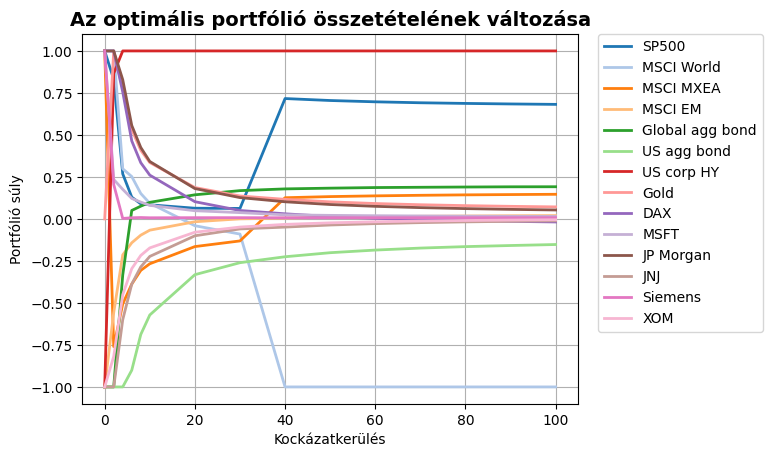

In [20]:
optimal_portfolios[mean_returns.index].plot(color = colors, linewidth = 2)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid()

plt.title("Az optimális portfólió összetételének változása", fontsize = 14, fontweight = 'bold')
plt.xlabel("Kockázatkerülés")
plt.ylabel("Portfólió súly")


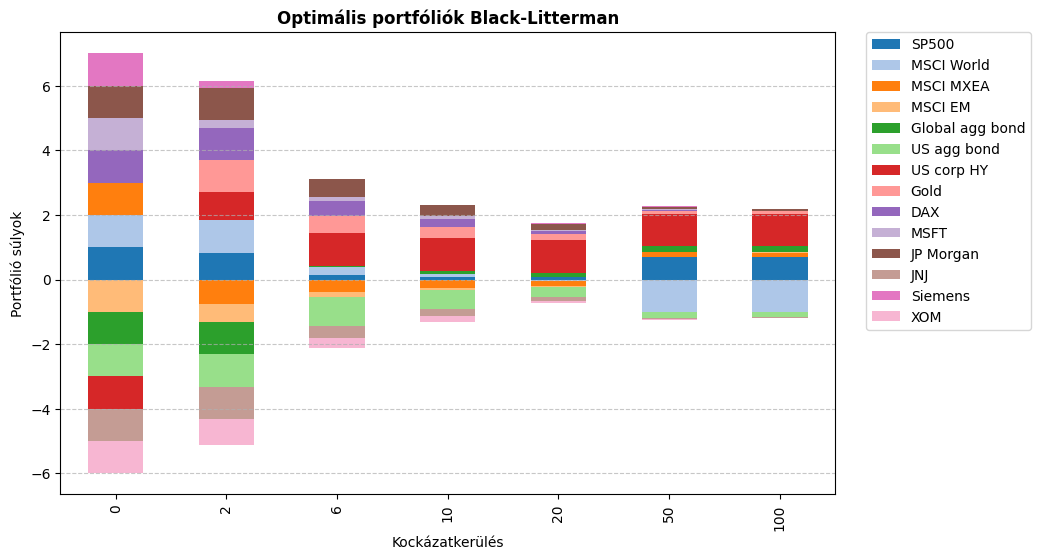

In [21]:
gamma_values = [0, 2, 6, 10, 20, 50, 100]
selected_portfolios = optimal_portfolios.loc[gamma_values, mean_returns.index]

selected_portfolios.plot(kind="bar", figsize=(10, 6), stacked = True, color = colors)

plt.xlabel("Kockázatkerülés")
plt.ylabel("Portfólió súlyok")
plt.title("Optimális portfóliók Black-Litterman", fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


### Shortselling nem engedélyezett

In [22]:
gamma = [0,2,4,6,8] + [10*x for x in range(1,11)]
uncer = 0.001   #ezen az erteken lehet valtoztatni

optimal_portfolios = pd.DataFrame(index=gamma, columns = list(mean_returns.index) + ['return', 'std'])

for g in gamma:
    initial_guess = np.array([1 / num_assets] * num_assets)
    result = minimize(lambda w: utility_function_bl(w, g, uncer), initial_guess,
                      method='SLSQP', bounds=bounds_without_shortselling,
                      constraints=constraints_weight())
    optimal_portfolios.loc[g] = list(result.x) + [portfolio_return(result.x), np.sqrt(portfolio_variance(result.x))]


optimal_portfolios.head()

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM,return,std
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.269,0.219
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.248,0.643,0.000,0.110,0.000,0.242,0.167
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.306,0.530,0.000,0.164,0.000,0.233,0.159
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.139,0.053,0.263,0.432,0.000,0.113,0.000,0.220,0.135
8,0.012,0.000,0.000,0.000,0.000,0.000,0.000,0.210,0.133,0.221,0.366,0.000,0.057,0.000,0.210,0.121


Text(0, 0.5, 'Portfólió súly')

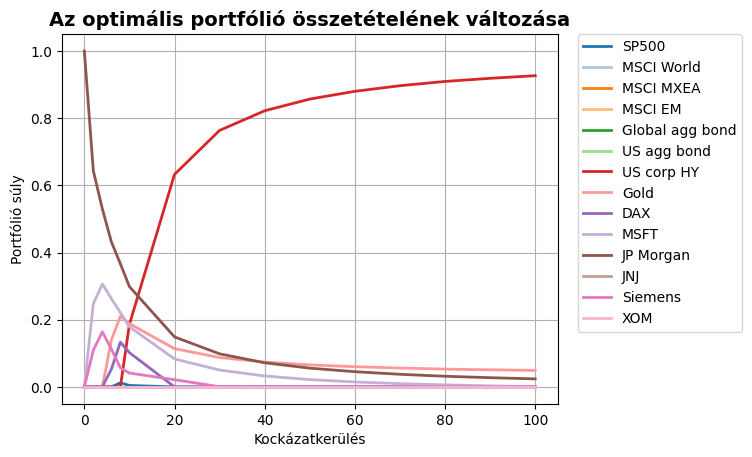

In [23]:
optimal_portfolios[mean_returns.index].plot(color = colors, linewidth = 2)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid()

plt.title("Az optimális portfólió összetételének változása", fontsize = 14, fontweight = 'bold')
plt.xlabel("Kockázatkerülés")
plt.ylabel("Portfólió súly")

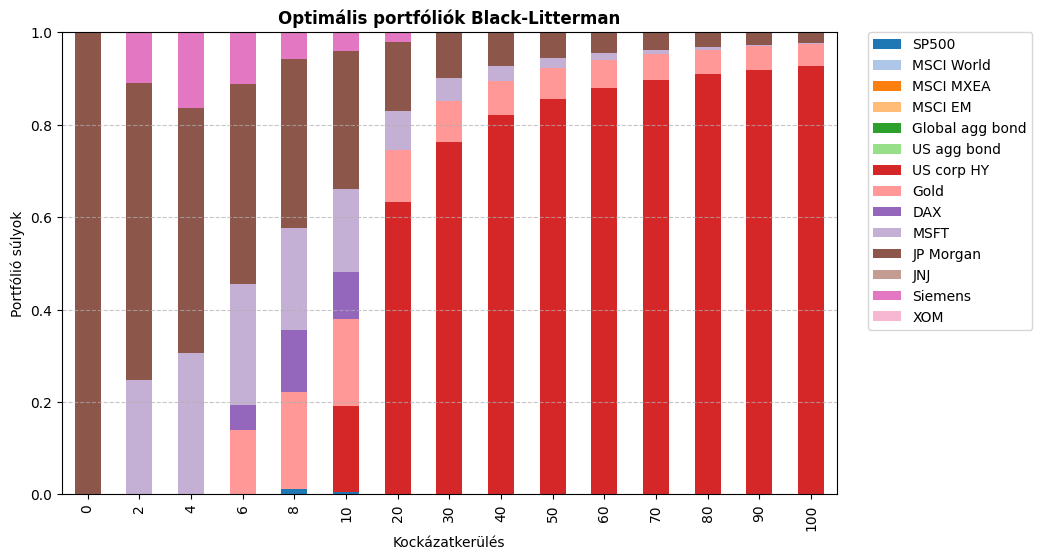

In [24]:
gamma_values = gamma
selected_portfolios = optimal_portfolios.loc[gamma_values, mean_returns.index]

selected_portfolios.plot(kind="bar", figsize=(10, 6), stacked = True, color = colors)

plt.xlabel("Kockázatkerülés")
plt.ylabel("Portfólió súlyok")
plt.title("Optimális portfóliók Black-Litterman", fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


## A bizonytalanságon változtatunk

### Shortselling engedélyezett

In [25]:
gamma = 5  #ide mas gamma is mehetne
uncertainty_list = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
optimal_portfolios = pd.DataFrame(index=uncertainty_list, columns = list(mean_returns.index) + ['return', 'std'])

for unc in uncertainty_list:
    initial_guess = np.array([1 / num_assets] * num_assets)
    result = minimize(lambda w: utility_function_bl(w, gamma, unc), initial_guess,
                      method='SLSQP', bounds=bounds_short_allowed,
                      constraints=constraints_weight())
    optimal_portfolios.loc[unc] = list(result.x) + [portfolio_return(result.x), np.sqrt(portfolio_variance(result.x))]


optimal_portfolios.head()

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM,return,std
0.000,1.000,-0.089,-0.898,-0.413,-1.000,-0.336,1.000,1.000,1.000,0.037,1.000,-0.812,0.040,-0.529,0.856,0.365
0.001,0.145,0.306,-0.455,-0.164,-0.046,-1.000,1.000,0.633,0.587,0.149,0.669,-0.470,0.003,-0.357,0.551,0.240
0.005,-0.064,0.475,-0.196,0.107,0.019,-1.000,1.000,0.134,0.417,0.096,0.281,-0.079,-0.045,-0.144,0.290,0.150
0.010,-0.113,0.512,-0.156,0.165,0.038,-1.000,1.000,0.044,0.391,0.060,0.182,0.022,-0.066,-0.080,0.224,0.132
0.050,-0.525,1.000,-0.240,0.225,0.015,-0.940,1.000,-0.033,0.365,0.022,0.088,0.130,-0.098,-0.009,0.154,0.117


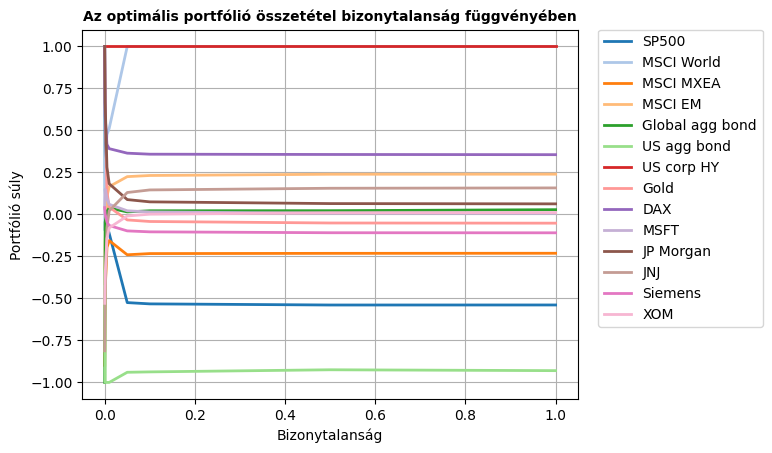

In [26]:
num_assets = len(mean_returns.index)

optimal_portfolios[mean_returns.index].plot(color=colors, linewidth=2)

plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=10)
plt.grid()
plt.title("Az optimális portfólió összetétel bizonytalanság függvényében",fontsize = 10, fontweight="bold")
plt.xlabel("Bizonytalanság")
plt.ylabel("Portfólió súly")

plt.show()

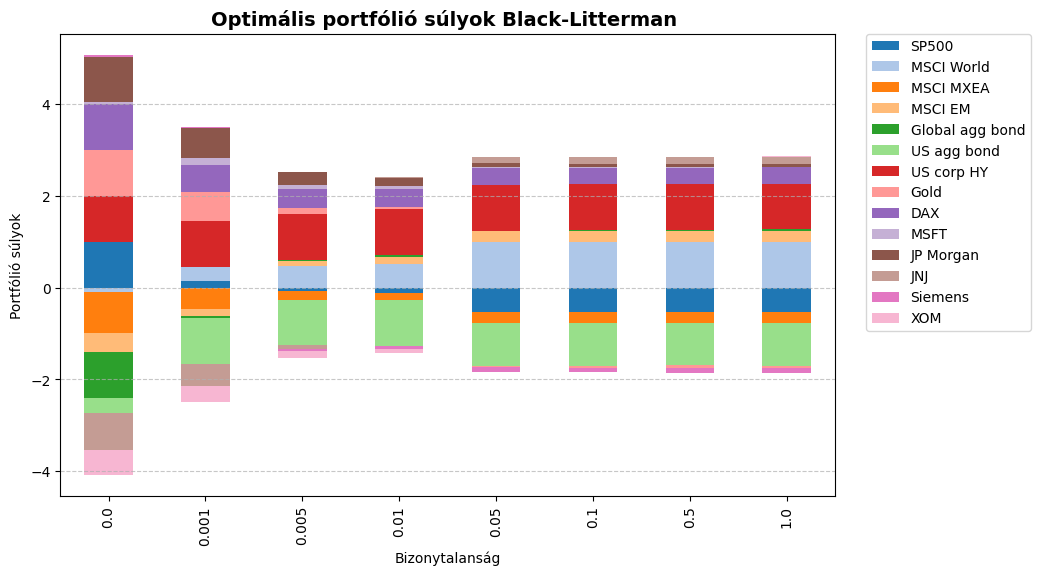

In [27]:
uncertainty_list = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
selected_portfolios = optimal_portfolios.loc[uncertainty_list, mean_returns.index]

selected_portfolios.plot(kind="bar", figsize=(10, 6), stacked=True, color = colors)

plt.xlabel("Bizonytalanság")
plt.ylabel("Portfólió súlyok")
plt.title("Optimális portfólió súlyok Black-Litterman ", fontsize = 14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Shortselling nem engedélyezett

In [28]:
gamma = 5  #ide mas gamma is mehetne
uncertainty_list = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
optimal_portfolios = pd.DataFrame(index=uncertainty_list, columns = list(mean_returns.index) + ['return', 'std'])

for unc in uncertainty_list:
    initial_guess = np.array([1 / num_assets] * num_assets)
    result = minimize(lambda w: utility_function_bl(w, gamma, unc), initial_guess,
                      method='SLSQP', bounds=bounds_without_shortselling,
                      constraints=constraints_weight())
    optimal_portfolios.loc[unc] = list(result.x) + [portfolio_return(result.x), np.sqrt(portfolio_variance(result.x))]


optimal_portfolios.head()

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM,return,std
0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.285,0.000,0.129,0.545,0.000,0.041,0.000,0.226,0.134
0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.078,0.000,0.291,0.480,0.000,0.151,0.000,0.227,0.147
0.005,0.059,0.092,0.000,0.064,0.000,0.000,0.000,0.000,0.313,0.178,0.289,0.000,0.004,0.000,0.188,0.124
0.010,0.079,0.120,0.000,0.165,0.000,0.000,0.000,0.000,0.293,0.112,0.232,0.000,0.000,0.000,0.164,0.115
0.050,0.081,0.142,0.000,0.246,0.000,0.000,0.000,0.000,0.248,0.042,0.156,0.061,0.000,0.023,0.123,0.102


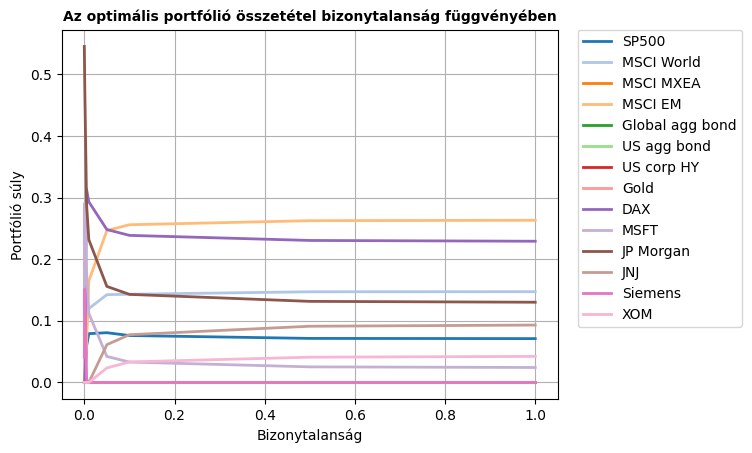

In [29]:
num_assets = len(mean_returns.index)

optimal_portfolios[mean_returns.index].plot(color=colors, linewidth=2)

plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=10)
plt.grid()
plt.title("Az optimális portfólió összetétel bizonytalanság függvényében",fontsize = 10, fontweight="bold")
plt.xlabel("Bizonytalanság")
plt.ylabel("Portfólió súly")

plt.show()

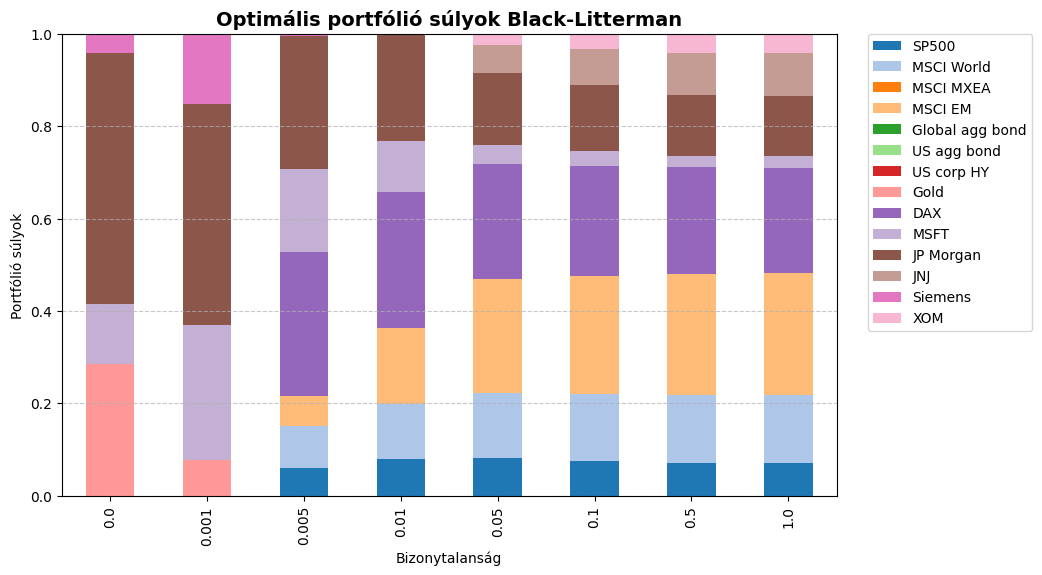

In [30]:
uncertainty_list = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
selected_portfolios = optimal_portfolios.loc[uncertainty_list, mean_returns.index]

selected_portfolios.plot(kind="bar", figsize=(10, 6), stacked=True, color = colors)

plt.xlabel("Bizonytalanság")
plt.ylabel("Portfólió súlyok")
plt.title("Optimális portfólió súlyok Black-Litterman", fontsize = 14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## View-k hatása

Most jön az a rész, hogy kibullyingolom a HY-et a piaci hozamokkal kapott portfólióból és beveszem az aranyat

In [31]:
# Mapping matrix: A 7. es a 8. eszközön van view
P = np.zeros((2, num_assets))
P[0, 6] = 1  # Negativ view
P[1, 7] = 1  # Pozitiv view

Q = np.array([[0.05], [0.15]])  # Adjust values for stronger/weaker views

# List of uncertainty levels (decreasing = stronger belief in views)
uncertainty_list = [ 1, 0.1, 0.01, 0.005, 0.002, 0.001, 0.00001, 0]

posterior_returns_dict = {}
posterior_cov_dict = {}

for i in uncertainty_list:
    omega = np.diag([i, i])
    bl = BlackLittermanModel(cov_matrix, pi=market_views, P=P, Q=Q, omega=omega)
    posterior_returns_dict[i] = bl.bl_returns()
    posterior_cov_dict[i] = bl.bl_cov()



In [32]:
pd.options.display.float_format = '{:.2f}%'.format

posterior_returns = pd.DataFrame(posterior_returns_dict)
posterior_returns.columns = ['Views'] + [str(np.round(x,3)) for x in uncertainty_list[1:-1]] + ['Market']
posterior_returns * 100

,Views,0.1,0.01,0.005,0.002,0.001,0.0,Market
SP500,10.42%,10.43%,10.49%,10.55%,10.65%,10.70%,7.88%,7.40%
MSCI World,10.57%,10.58%,10.66%,10.74%,10.88%,10.97%,8.10%,7.60%
MSCI MXEA,10.47%,10.49%,10.61%,10.71%,10.92%,11.08%,8.25%,7.72%
MSCI EM,10.18%,10.19%,10.32%,10.44%,10.68%,10.88%,9.35%,9.02%
Global agg bond,5.54%,5.55%,5.67%,5.78%,6.00%,6.20%,5.39%,5.17%
US agg bond,4.79%,4.80%,4.92%,5.03%,5.26%,5.47%,4.76%,4.55%
US corp HY,6.89%,6.89%,6.91%,6.93%,6.96%,6.95%,5.27%,5.00%
Gold,5.21%,5.29%,6.09%,6.83%,8.45%,10.07%,14.89%,15.00%
DAX,11.96%,11.97%,12.11%,12.23%,12.48%,12.65%,9.17%,8.53%
MSFT,10.08%,10.09%,10.17%,10.25%,10.39%,10.49%,8.01%,7.57%


In [33]:
gamma = 5  #ide mas gamma is mehetne
optimal_portfolios = pd.DataFrame(index=uncertainty_list, columns = list(mean_returns.index) + ['return', 'std'])

for unc in uncertainty_list:
    initial_guess = np.array([1 / num_assets] * num_assets)
    result = minimize(lambda w: utility_function_bl(w, gamma, unc), initial_guess,
                      method='SLSQP', bounds=bounds_short_allowed,
                      constraints=constraints_weight())
    optimal_portfolios.loc[unc] = list(result.x) + [portfolio_return(result.x), np.sqrt(portfolio_variance(result.x))]


optimal_portfolios.head()

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM,return,std
1.00%,-0.18%,0.54%,-0.12%,0.24%,0.11%,-1.00%,1.00%,-0.05%,0.36%,-0.00%,0.06%,0.15%,-0.11%,0.01%,0.13%,0.11%
0.10%,-0.54%,1.00%,-0.23%,0.24%,0.02%,-0.93%,1.00%,-0.04%,0.36%,0.00%,0.06%,0.16%,-0.11%,0.01%,0.13%,0.11%
0.01%,-0.54%,1.00%,-0.23%,0.23%,-0.01%,-0.96%,1.00%,0.03%,0.36%,0.00%,0.06%,0.16%,-0.11%,0.01%,0.14%,0.11%
0.01%,-0.54%,1.00%,-0.23%,0.23%,-0.04%,-0.98%,1.00%,0.11%,0.36%,0.00%,0.05%,0.16%,-0.11%,0.00%,0.16%,0.11%
0.00%,-0.53%,1.00%,-0.21%,0.22%,-0.05%,-0.97%,0.82%,0.26%,0.37%,-0.00%,0.05%,0.15%,-0.11%,0.00%,0.17%,0.12%


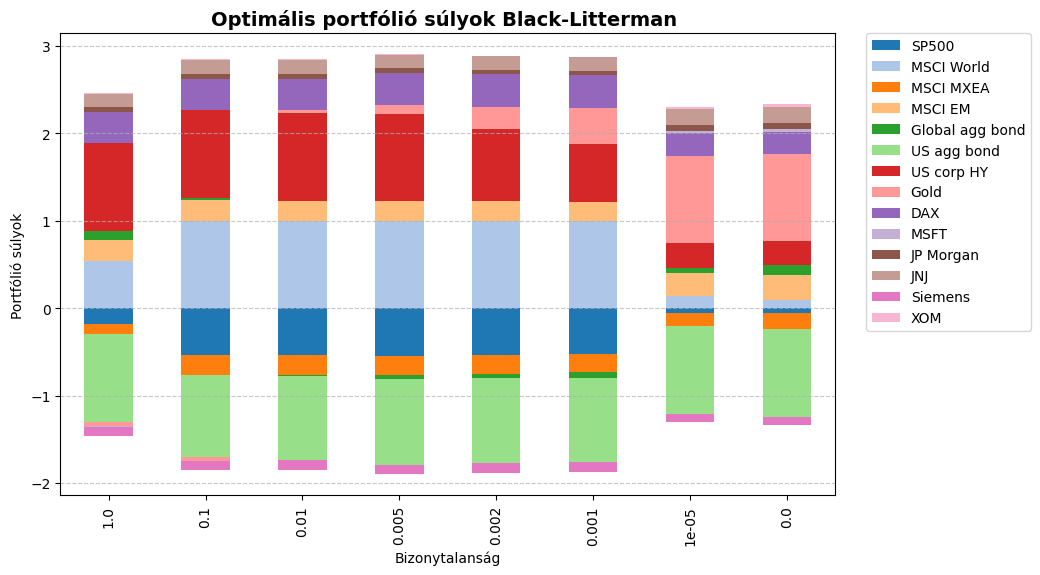

In [34]:
selected_portfolios = optimal_portfolios.loc[uncertainty_list, mean_returns.index]

selected_portfolios.plot(kind="bar", figsize=(10, 6), stacked=True, color = colors)

plt.xlabel("Bizonytalanság")
plt.ylabel("Portfólió súlyok")
plt.title("Optimális portfólió súlyok Black-Litterman ", fontsize = 14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()